# Using EcoFOCIpy to apply Data Filters to 1D data

- filter examples:
    - 35hr Lanzcos Filter **good for data with tides like ADCP**
    - IQR (inter-quartile range) filter
    - STD (standard deviation) filter
    - 7pt rolling mean-value exceeds 5std of timeseries demeaned data **good for spiky data like chlor, sal in interface** and should be applied when there is a seasonal baseline shift (duration of rolling mean?) *TODO: make subroutine and output flag to variables*
    
    
- input:
    - timeseries data
- output:
    - timeseries data, flags
    
TODO:
- linearly fill (foward or back?) no more than x number of points (likely 1) -> interp_na(limit=1)
- output to xarray modified netcdf file

In [16]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import datetime

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific

In [19]:
# testfile = '../staticdata/example_data/nc_data/16bsm2a_eco_0000m.nc'
testfile = '/Users/bell/ecoraid/2018/Moorings/18ckv2a/working/18ckv2a_ecf_0016m.interpolated.trimmed_missing.cf.nc'

So lets load a timeseries and apply filters to the entire period

In [20]:
xdf = xa.load_dataset(testfile)
xdf

<xarray.Dataset>
Dimensions:        (depth: 1, lat: 1, lon: 1, time: 8766)
Coordinates:
  * time           (time) datetime64[ns] 2018-08-13T22:00:00 ... 2019-08-14T0...
  * depth          (depth) float32 16.0
  * lat            (lat) float32 71.22
  * lon            (lon) float32 164.2
Data variables:
    fluor_3031     (time, depth, lat, lon) float32 95.41 80.02 ... 1.679e+03
    Fch_906        (time, depth, lat, lon) float32 0.3873 0.2642 ... 13.05
    fluorstd_2031  (time, depth, lat, lon) float32 1.199 1.113 ... 16.49 273.9
Attributes: (12/14)
    CREATION_DATE:        August 02, 2021 23:28 UTC
    COMPOSITE:            1
    INST_TYPE:            eco
    DATA_CMNT:            18ckv2a_flsb_158_14m.txt
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    ...                   ...
    MOORING:              18ckv2a
    WATER_MASS:           
    EXPERIMENT:           
    PROJECT:              
    History:              \nOctober 24, 2019 22:16 UTC Data Trimmed\n\nAugust...
    featureType:

In [22]:
var_choice = 'Fch_906'

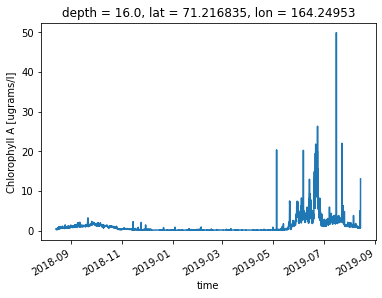

In [23]:
xdf[var_choice].plot()

In [24]:
df = xdf[var_choice][:,0,0,0].to_dataframe().drop(labels=['depth','lat','lon'],axis=1)
dft = df.dropna()
#
## missing data fill limited by number of hours to linearly interpolate
temp = dft[var_choice].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = dft[var_choice].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[var_choice].mean()

In [25]:
IQRcleaned = cleaning.outlier_bounds_iqr(xdf[var_choice])
STDcleaned = cleaning.outlier_bounds_std(xdf[var_choice])

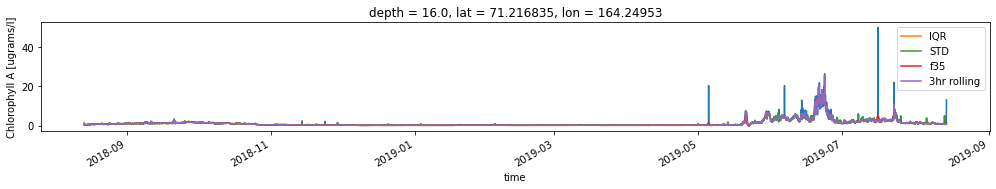

In [29]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()


But perhaps a form of rolling std/iqr filter is more appropriate as it wont tend to mask relevant peaks by being a median filter

In [27]:
xdf

<xarray.Dataset>
Dimensions:        (depth: 1, lat: 1, lon: 1, time: 8766)
Coordinates:
  * time           (time) datetime64[ns] 2018-08-13T22:00:00 ... 2019-08-14T0...
  * depth          (depth) float32 16.0
  * lat            (lat) float32 71.22
  * lon            (lon) float32 164.2
Data variables:
    fluor_3031     (time, depth, lat, lon) float32 95.41 80.02 ... 1.679e+03
    Fch_906        (time, depth, lat, lon) float32 0.3873 0.2642 ... 13.05
    fluorstd_2031  (time, depth, lat, lon) float32 1.199 1.113 ... 16.49 273.9
Attributes: (12/14)
    CREATION_DATE:        August 02, 2021 23:28 UTC
    COMPOSITE:            1
    INST_TYPE:            eco
    DATA_CMNT:            18ckv2a_flsb_158_14m.txt
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    ...                   ...
    MOORING:              18ckv2a
    WATER_MASS:           
    EXPERIMENT:           
    PROJECT:              
    History:              \nOctober 24, 2019 22:16 UTC Data Trimmed\n\nAugust...
    featureType:

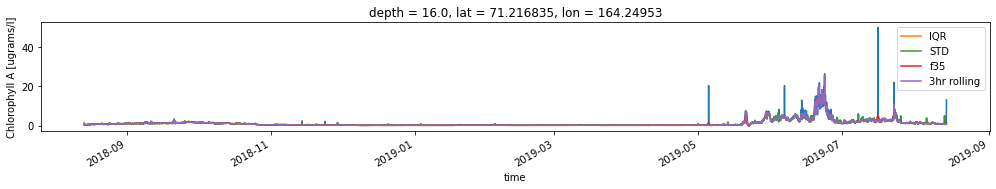

In [30]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()


*Finally* try to refill as many points back to the start and finish of the 

In [32]:
N = 3
clean = cleaning.rolling_outlier_std(xdf,var_choice,timebase=N*2+1,stddev=5,interp_fill_timebase='1H')

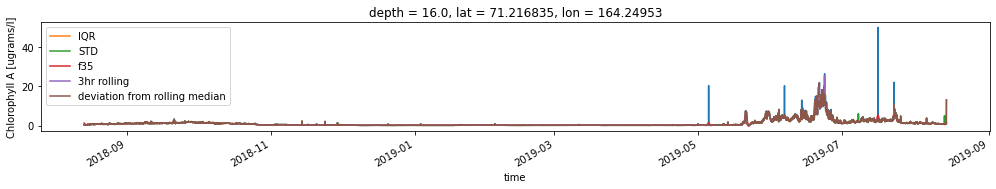

In [33]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()


In [35]:
clean.to_dataframe().to_csv(testfile.replace('.nc','.despiked.csv'))

In [36]:
clean

<xarray.Dataset>
Dimensions:        (depth: 1, lat: 1, lon: 1, time: 8766)
Coordinates:
  * time           (time) datetime64[ns] 2018-08-13T22:00:00 ... 2019-08-14T0...
  * depth          (depth) float32 16.0
  * lat            (lat) float32 71.22
  * lon            (lon) float32 164.2
Data variables:
    fluor_3031     (time, depth, lat, lon) float32 95.41 80.02 ... 1.679e+03
    Fch_906        (time, depth, lat, lon) float32 0.3873 0.2642 ... 13.05
    fluorstd_2031  (time, depth, lat, lon) float32 1.199 1.113 ... 16.49 273.9
    Fch_906_QC     (time, depth, lat, lon) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes: (12/14)
    CREATION_DATE:        August 02, 2021 23:28 UTC
    COMPOSITE:            1
    INST_TYPE:            eco
    DATA_CMNT:            18ckv2a_flsb_158_14m.txt
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    ...                   ...
    MOORING:              18ckv2a
    WATER_MASS:           
    EXPERIMENT:           
    PROJECT:              
    History:              \nOctober 24, 2019 22:16 UTC Data Trimmed\n\nAugust...
    featureType: